## 处理现金流数据
相关函数已经整合到cfProcessTools

In [1]:
import pandas as pd
import numpy as np
dirPath = "/Users/zch/Desktop/化工/"

In [2]:
fileName = "化工经营性现金净流量同比增长.xlsx"
df = pd.read_excel(dirPath+fileName)

In [10]:
columns = ["code", "name"]
for year in range(2000, 2021):
    for quarter in [3, 6, 9, 12]:
        columns.append(f"{year}-{quarter:02}")
df.columns = columns

In [12]:
df

,code,name,2000-03,2000-06,2000-09,2000-12,2001-03,2001-06,2001-09,2001-12,...,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09,2020-12
0,900921.SH,丹科B股,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2755.5407,-67.9435,-48.8315,141.5385,29.6827,-653.2174,-19.5520,227.3996,-112.5938,NaN
1,900909.SH,华谊B股,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-34.7662,-30.2452,79.5601,-150.6823,-119.2857,-13.2463,-69.5177,158.0352,783.8692,NaN
2,900908.SH,氯碱B股,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,283.7478,-42.9409,-710.4986,209.5122,-27.0408,3.7611,6.8411,7.2631,-30.2405,NaN
3,833819.OC,颖泰生物,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,285.0225,165.8279,512.9760,647.8950,-46.2259,-56.0480,8.2960,-49.6030,272.9440,NaN
4,688669.SH,聚石化学,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,000408.SZ,*ST藏格,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,407.2310,51.2936,167.1266,187.0787,-96.9360,-84.8825,68.3184,908.0043,-1489.5817,NaN
391,000301.SZ,东方盛虹,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-98.8161,686.0180,7576.7975,1050.3983,138783.7633,76.7012,-185.6933,49.4647,-10.9407,NaN
392,000159.SZ,国际实业,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-393.9524,344.5212,-629.3976,-86.9218,29.6609,102.6707,68.1268,-255.6725,114.7615,NaN
393,000096.SZ,广聚能源,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-12.0766,90.9346,-82.9760,1174.1779,68.0498,1.8738,-96.5556,-29.0729,11.6126,NaN


In [14]:
# 去除ST
df = df[~df["name"].str.contains("ST")]

In [15]:
# 去除空行
df = df[~df["name"].isnull()]

In [17]:
# 去除全为空的列，即没有数据的年份
df.dropna(how="all", axis=1, inplace=True)

In [19]:
# 去除近年没有数据的公司
# 不能用最后一列，改用后两列
c1 = df.columns[-1]
c2 = df.columns[-2]
df = df[~((df[c1].isnull())&(df[c2].isnull()))] 

In [21]:
def isContinuous(x, n=1):
    '''
    Description:
    筛选出中断的公司，中断期不超过n
    ---
    Params:
    x, for df.apply(), a row Series
    n, int
    ---
    Returns:
    bool, True 表示连续, False means discontinuity
    '''
    it = iter(x)
    # 确保有元素且不全为nan
    while isinstance(next(it), str):
        pass
    while np.isnan(next(it)):
        pass
    count = 0
    while True:
        try:
            temp = next(it)
            if np.isnan(temp):
                count += 1
                if count > n:
                    return False
        except StopIteration:
            return True

In [22]:
# 去除不连续的公司，空缺roe不超过1
df = df[df.apply(lambda x:isContinuous(x), axis=1)]

In [24]:
# 去除少于32季度数据的公司
minNum = 32
df = df[df.count(axis=1) > minNum+2]

In [27]:
df.to_excel("化工经营性现金净流量同比增长clean.xlsx", index=False)

In [28]:
fileName2 = "化工现金净流量同比增长率.xlsx"
fileName3 = "化工净利润同比增长率.xlsx"

In [106]:
def cleanCFData(df, startYear=2000, endYear=2021, minNum=32, continuousBool=True):
    '''
    Description:
    清洗现金流相关季度数据
    - 去除空行
    - 去除ST
    - 去除最近两季度没有数据的公司
    - 去除不连续公司
    - 去除数据量少于minNum的公司
    ---
    Params:
    startYear, default 2000
    endYear, default 2021
    minNum, default 32
    continuousBool
    ---
    Returns:
    DataFrame
    '''
    columns = ["code", "name"]
    for year in range(startYear, endYear):
        for quarter in [3, 6, 9, 12]:
            columns.append(f"{year}-{quarter:02}")
    df.columns = columns
    # 去除ST
    df = df[~df["name"].str.contains("ST")]
    # 去除空行
    df = df[~df["name"].isnull()]
    # 去除全为空的列，即没有数据的年份
    df.dropna(how="all", axis=1, inplace=True)
    # 去除近年没有数据的公司
    # 不能用最后一列，改用后两列
    c1 = df.columns[-1]
    c2 = df.columns[-2]
    df = df[~((df[c1].isnull())&(df[c2].isnull()))] 
    if continuousBool:
        # 去除不连续的公司，空缺roe不超过1
        df = df[df.apply(lambda x:isContinuous(x), axis=1)]
    # 去除少于32季度数据的公司
    df = df[df.count(axis=1) > minNum+2]
    return df

In [31]:
df = pd.read_excel(dirPath+fileName)
df = cleanCFData(df)

df2 = pd.read_excel(dirPath+fileName2)
df2 = cleanCFData(df2)

df3 = pd.read_excel(dirPath+fileName3)
df3 = cleanCFData(df3)

df.to_excel(fileName[:-5]+"clean.xlsx", index=False)
df2.to_excel(fileName2[:-5]+"clean.xlsx", index=False)
df3.to_excel(fileName3[:-5]+"clean.xlsx", index=False)

In [32]:
fileName4 = "化工每股现金净流量.xlsx"
df4 = pd.read_excel(dirPath+fileName)

In [34]:
df4 = cleanCFData(df4)

In [36]:
df4.to_excel(fileName4[:-5]+"clean.xlsx", index=False)

In [50]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
zhfont = FontProperties(fname="/System/Library/Fonts/PingFang.ttc")

In [44]:
from datetime import datetime

In [41]:
temp = df4.iloc[:1, :]

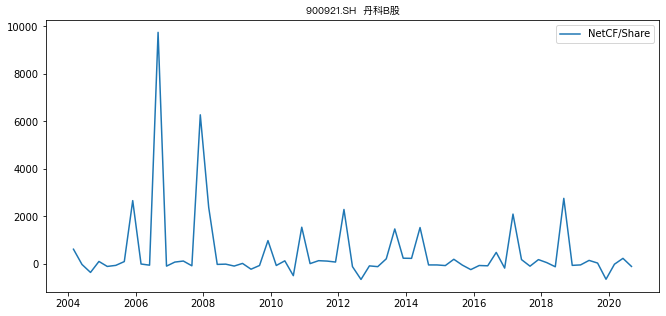

In [52]:
fig, axs = plt.subplots(figsize=(11, 5))
x = [datetime.strptime(d, '%Y-%m').date() for d in temp.columns[2:]]
y = temp.iloc[0, 2:]
axs.plot(x, y, label="NetCF/Share")
title = temp.iloc[0, 0]+"  "+temp.iloc[0, 1]
axs.set_title(title, fontproperties=zhfont)  # code
axs.legend()

In [53]:
def demoOne(temp):
    '''
    Description:
    绘制一个公司的
    ---
    Params:
    temp, 只有一行的DataFrame
    ---
    Returns:
    '''
    fig, axs = plt.subplots(figsize=(11, 5))
    x = [datetime.strptime(d, '%Y-%m').date() for d in temp.columns[2:]]
    y = temp.iloc[0, 2:]
    axs.plot(x, y, label="NetCF/Share")
    title = temp.iloc[0, 0]+"  "+temp.iloc[0, 1]
    axs.set_title(title, fontproperties=zhfont)  # code
    axs.legend()

In [89]:
# winsorize
df.iloc[:, 2:] = df.iloc[:, 2:].apply(lambda x: np.clip(
    x, np.nanquantile(x, 0.1), np.nanquantile(x, 0.9)), axis=1)

In [91]:
# tempCodes = np.random.choice(codes, size=10)
# print()
# for code in tempCodes:
#     demoOne(df[df["code"]==code])

In [95]:
fileName5 = "化工经营活动产生的现金流净额比经营活动净收益.xlsx"
fileName6 = "化工经营活动产生的现金流净额比营业收入.xlsx"
df5 = pd.read_excel(dirPath+fileName5)
df6 = pd.read_excel(dirPath+fileName6)
df5 = cleanCFData(df5)
df6 = cleanCFData(df6)
df5.to_excel(fileName5[:-5]+"clean.xlsx", index=False)
df6.to_excel(fileName6[:-5]+"clean.xlsx", index=False)

In [101]:
codes = df6.code.values
tempCodes = np.random.choice(codes, size=10)
print()
# for code in tempCodes:
#     demoOne(df6[df6["code"]==code])

In [98]:
# TTM 数据
file1 = "化工经营活动产生的现金流净额比营业收入TTM.xlsx"
file2 = "化工经营活动产生的现金流净额比经营活动净收益TTM.xlsx"
file3 = "化工经营活动产生的现金流净额比营业利润TTM.xlsx"

In [107]:
ttm1 = pd.read_excel(dirPath+file1)
ttm2 = pd.read_excel(dirPath+file2)
ttm3 = pd.read_excel(dirPath+file3)
ttm1 = cleanCFData(ttm1, continuousBool=False)
ttm2 = cleanCFData(ttm2, continuousBool=False)
ttm3 = cleanCFData(ttm3, continuousBool=False)

In [108]:
ttm1.to_excel("ttmData/"+file1[:-5]+"clean.xlsx", index=False)
ttm2.to_excel("ttmData/"+file2[:-5]+"clean.xlsx", index=False)
ttm3.to_excel("ttmData/"+file3[:-5]+"clean.xlsx", index=False)

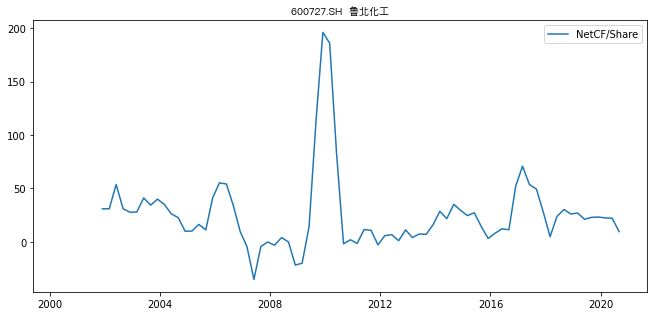

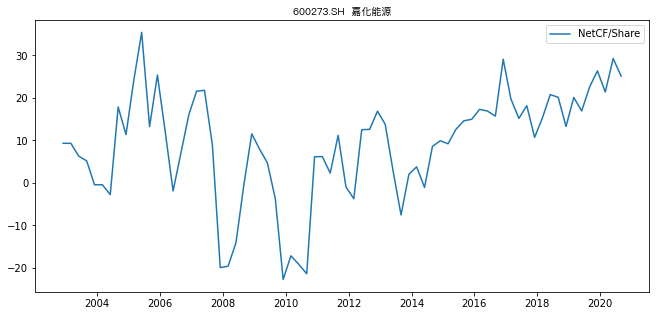

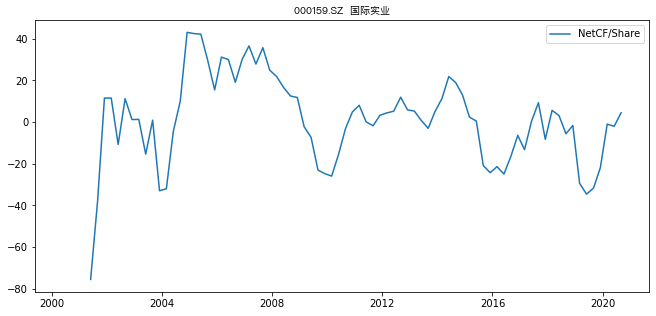

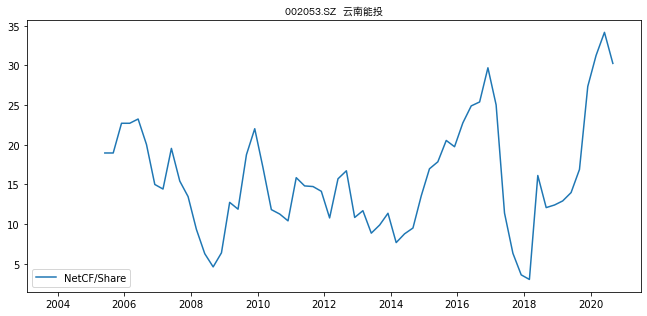

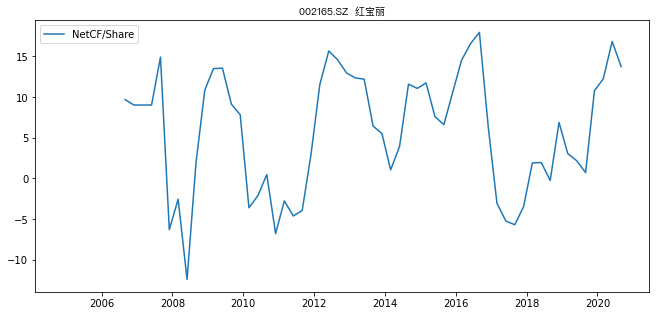

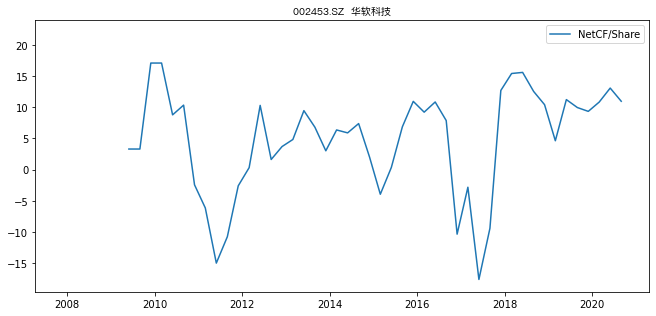

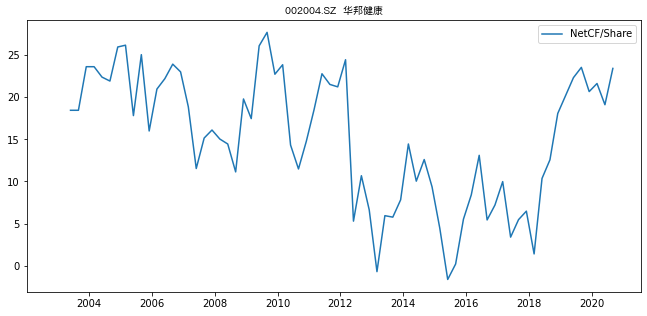

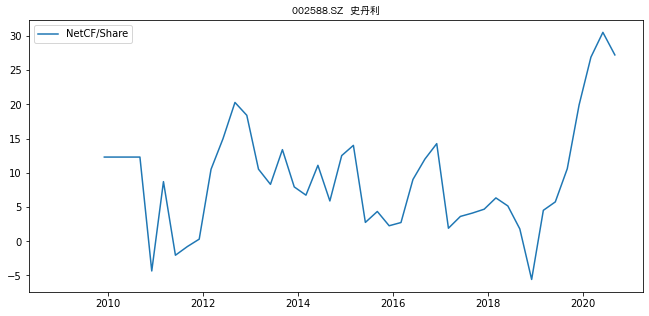

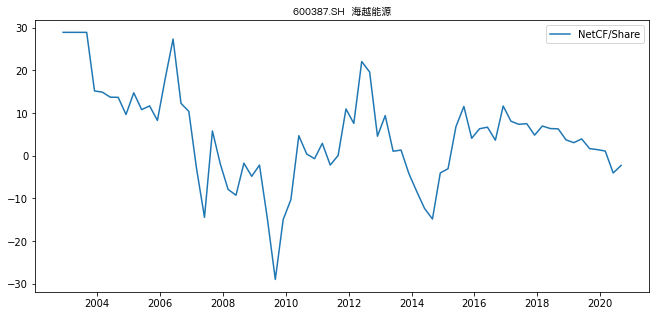

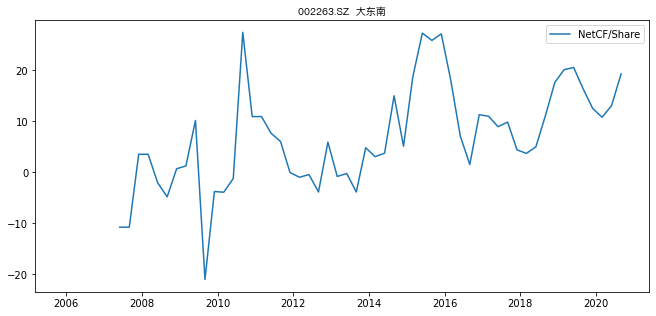

In [109]:
codes = ttm1.code.values
tempCodes = np.random.choice(codes, size=10)
print()
for code in tempCodes:
    demoOne(ttm1[ttm1["code"]==code])

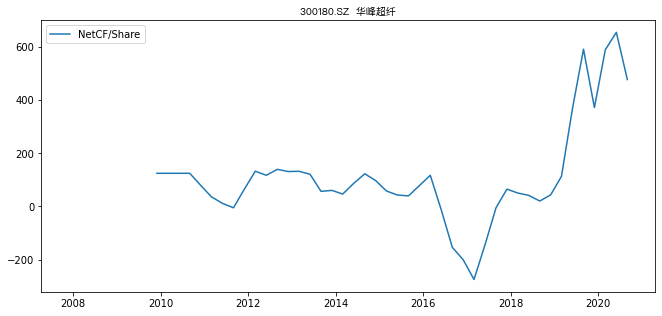

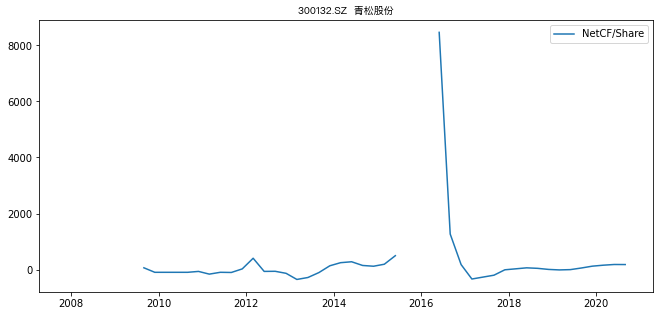

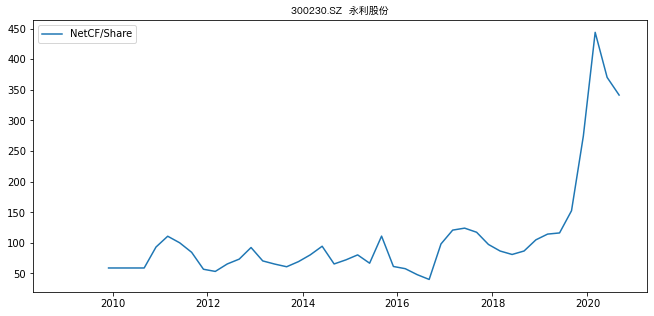

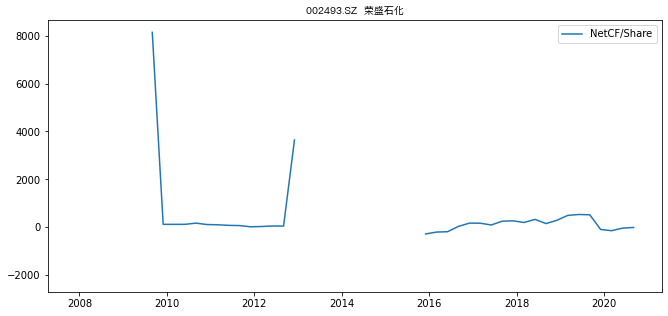

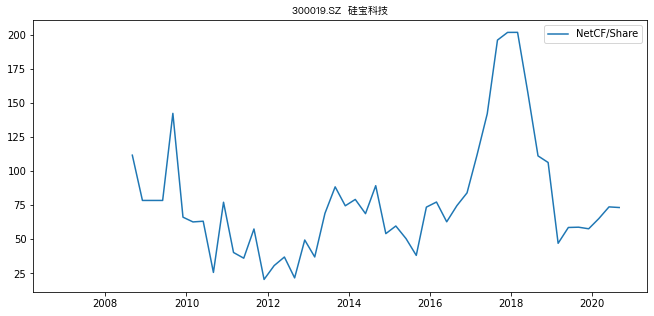

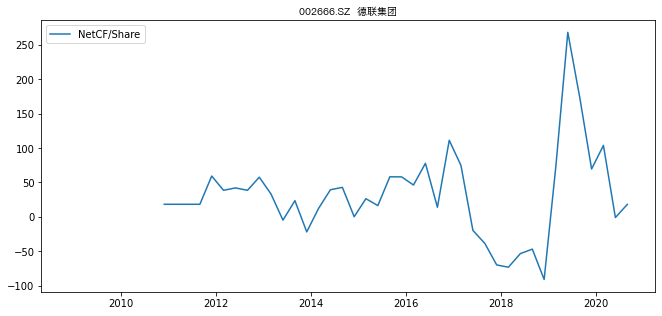

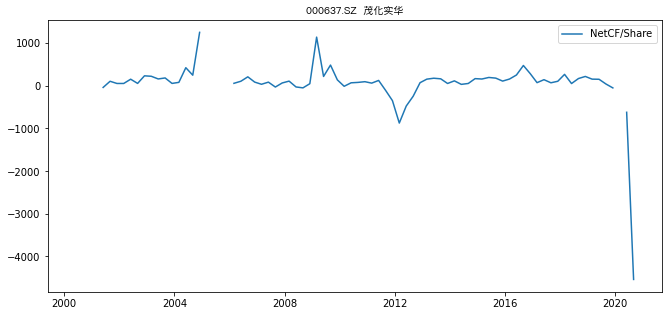

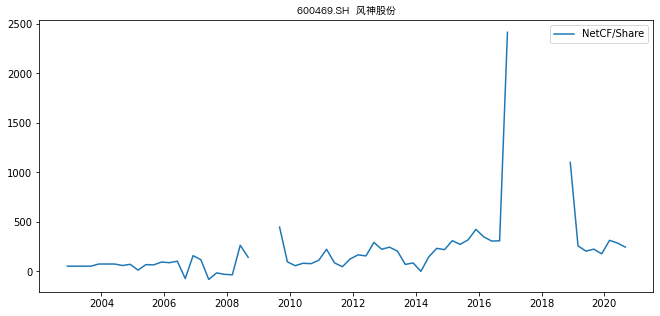

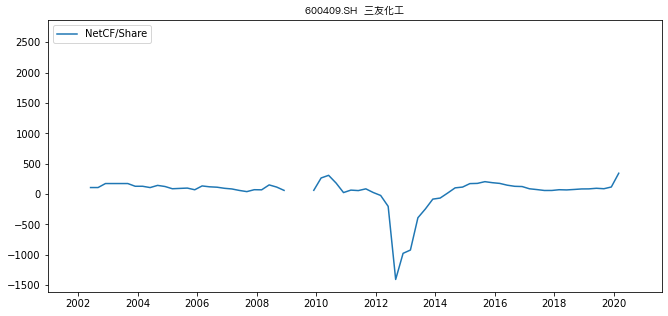

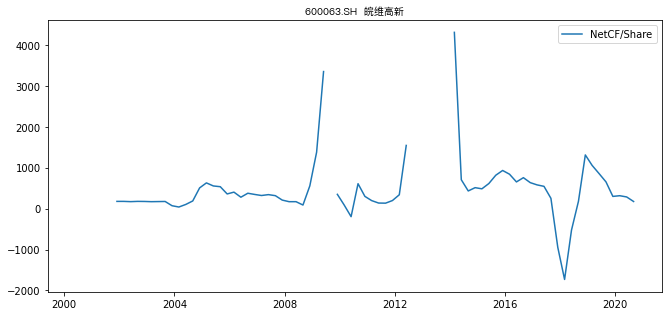

In [110]:
codes = ttm2.code.values
tempCodes = np.random.choice(codes, size=10)
print()
for code in tempCodes:
    demoOne(ttm2[ttm2["code"]==code])

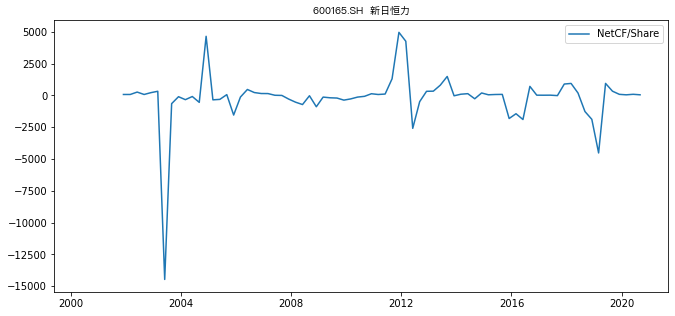

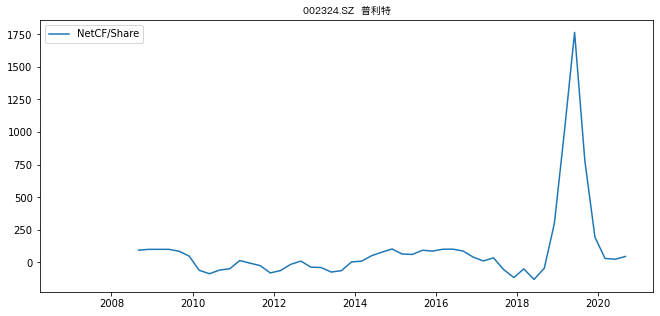

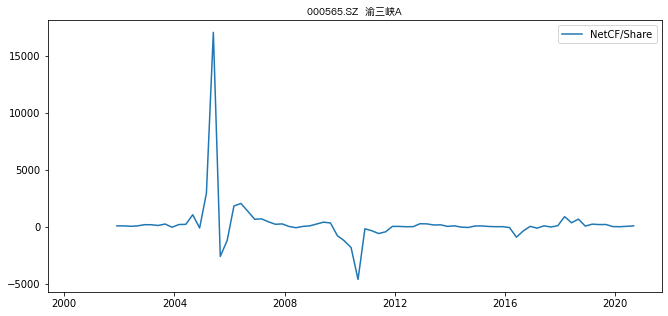

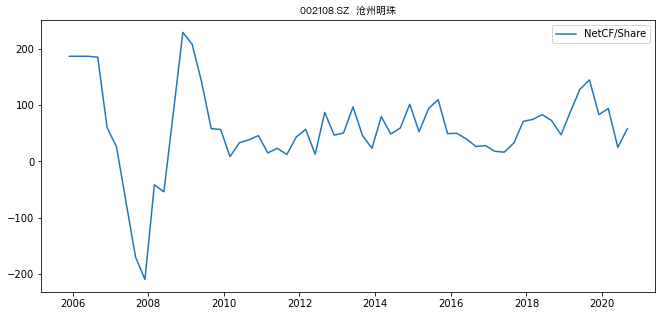

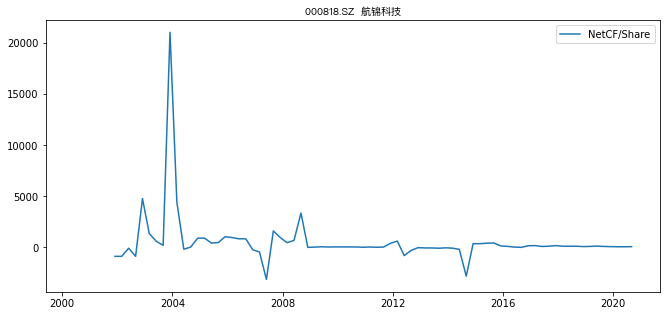

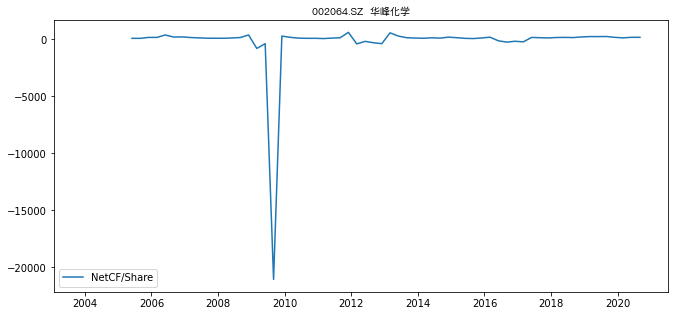

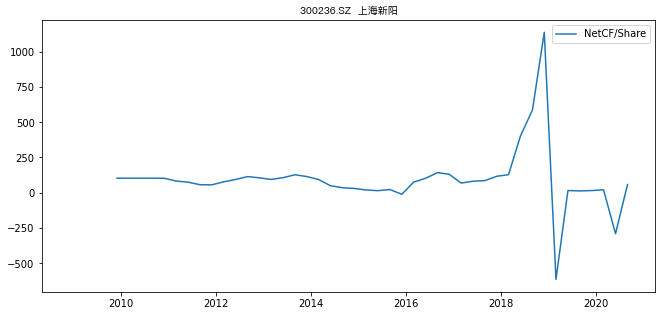

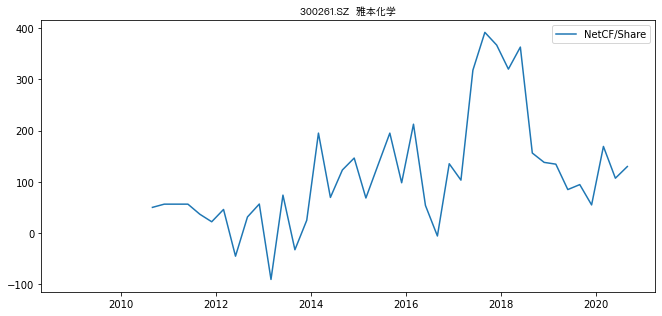

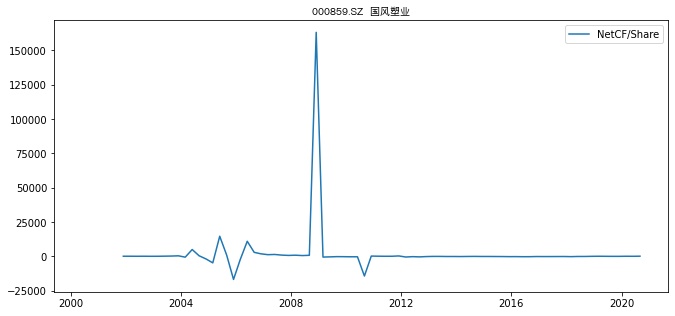

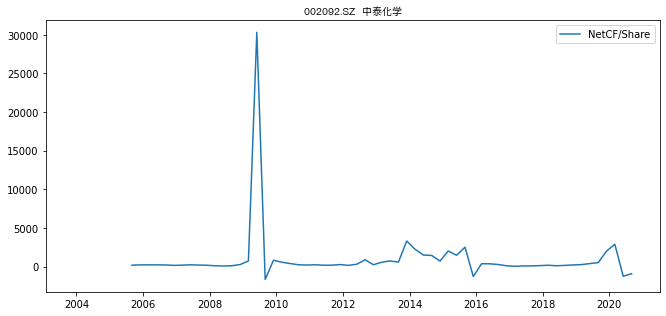

In [112]:
codes = ttm3.code.values
tempCodes = np.random.choice(codes, size=10)
print()
for code in tempCodes:
    demoOne(ttm3[ttm3["code"]==code])

1